<a href="https://colab.research.google.com/github/arcursino/tcc_mba/blob/main/TCC_Ariana_Cursino_Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalações

In [2]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install --upgrade scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_categorical_dtype
import pymc as pm
import arviz as az
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, classification_report, mean_absolute_error, mean_squared_error
import bambi as bmb
import arviz as az

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)


In [6]:
# Import machine learning methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [7]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [8]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pre-Processo

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df = pd.read_csv('/content/drive/MyDrive/TCC_MBA/alignment_synthetic_data.csv')

In [11]:
def remover_colunas_numericas_constantes(df):
    """
    Identifica e remove colunas numéricas de um DataFrame pandas
    que possuem um valor constante em todas as linhas.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.

    Returns:
        tuple: Uma tupla contendo:
            - pd.DataFrame: O DataFrame com as colunas constantes removidas.
            - list: Uma lista com os nomes das colunas que foram removidas.
    """
    print("Iniciando a avaliação das colunas...")

    # 1. Selecionar apenas as colunas que são de tipos numéricos
    # Usamos np.number para incluir todos os tipos numéricos (int, float, etc.)
    colunas_numericas = df.select_dtypes(include=np.number).columns
    print(f"Total de colunas numéricas encontradas: {len(colunas_numericas)}")

    # Lista para armazenar os nomes das colunas a serem removidas
    colunas_para_remover = []

    # 2. Iterar sobre as colunas numéricas e verificar se são constantes
    print("Verificando colunas numéricas para constância...")
    for coluna in colunas_numericas:
        # Verifica o número de valores únicos na coluna
        # Se for 1, significa que todos os valores são iguais
        if df[coluna].nunique() == 1:
            colunas_para_remover.append(coluna)
            print(f"  - Coluna '{coluna}' é constante e será removida.")
        # else: # Opcional: para ver quais colunas numéricas NÃO são constantes
        #     print(f"  - Coluna '{coluna}' não é constante.")


    # 3. Remover as colunas identificadas do DataFrame original
    if colunas_para_remover:
        print(f"\nRemovendo {len(colunas_para_remover)} coluna(s) constante(s)...")
        df_limpo = df.drop(columns=colunas_para_remover)
        print("Remoção concluída.")
    else:
        print("\nNenhuma coluna numérica constante encontrada. O DataFrame permanece inalterado.")
        df_limpo = df.copy() # Retorna uma cópia para manter a consistência

    print("\nAvaliação e remoção finalizadas.")

    # Retorna o DataFrame limpo e a lista de colunas removidas
    return df_limpo, colunas_para_remover

In [12]:
df_limpo, colunas_removidas = remover_colunas_numericas_constantes(df)

Iniciando a avaliação das colunas...
Total de colunas numéricas encontradas: 26
Verificando colunas numéricas para constância...
  - Coluna 'CAMBER_FL_INITIAL' é constante e será removida.
  - Coluna 'CAMBER_FR_INITIAL' é constante e será removida.
  - Coluna 'CAMBER_RL_INITIAL' é constante e será removida.
  - Coluna 'CAMBER_RR_INITIAL' é constante e será removida.

Removendo 4 coluna(s) constante(s)...
Remoção concluída.

Avaliação e remoção finalizadas.


# Modelos

## Train e Test

In [13]:
df_train = df_limpo[['cell_id', 'Vehicle_Type', 'Warranty',
       'Rear_Thrust_Angle_Final_Value', 'RIDE_HEIGHT_FA_DIFF',
       'RIDE_HEIGHT_FL', 'RIDE_HEIGHT_FL_INITIAL', 'RIDE_HEIGHT_FR',
       'RIDE_HEIGHT_RA_DIFF', 'RIDE_HEIGHT_RL', 'RIDE_HEIGHT_RR',
       'Steering_Wheel_Angle_Final_Value', 'Steering_Wheel_Angle_Preset_Value',
       'Front_Sum_Toe_Final_Value', 'TOE_FA_TOTAL_INITIAL', 'L_F_Toe',
       'TOE_FL_INITIAL', 'R_F_Toe', 'TOE_FR_INITIAL', 'TOE_RA_TOTAL',
       'TOE_RA_TOTAL_INITIAL', 'L_R_Toe', 'TOE_RL_INITIAL', 'R_R_Toe',
       'TOE_RR_INITIAL', 'CabStyle','Engine', 'RearWheels', 'SteeringGear',
        'Suspension', 'Tire', 'Transmission', 'Wheel', 'LaneDeparture', 'MY']].copy()

In [14]:
object_cols = df_train.select_dtypes(include='object').columns
for col in object_cols:
    df_train[col] = df_train[col].astype('category')

In [15]:
X_train, X_test = train_test_split(df_train, random_state=42, test_size=0.3)

In [16]:
id_and_categorical_cols = ['cell_id', 'Vehicle_Type', 'Warranty','CabStyle', 'Engine',
                           'RearWheels', 'SteeringGear', 'Suspension', 'Tire',
                           'Transmission', 'Wheel','LaneDeparture', 'MY']
numeric_cols = []

for col in X_train.columns:
  if is_numeric_dtype(df_limpo[col]):
    numeric_cols.append(col)

# Separar as colunas
X_train_numerical = X_train[numeric_cols]
X_train_ids_and_cats = X_train[id_and_categorical_cols]

# Separar as colunas
X_test_numerical = X_test[numeric_cols]
X_test_ids_and_cats = X_test[id_and_categorical_cols]

# --- Passo 3: Aplique a escala APENAS às colunas numéricas ---
scaler = StandardScaler() # Ou seu scaler de preferência
X_train_scaled_numerical_array = scaler.fit_transform(X_train_numerical)
X_test_scaled_numerical_array = scaler.fit_transform(X_test_numerical)

# --- Passo 4: Converta o array escalado de volta para DataFrame e combine com as colunas originais ---
# É crucial nomear as colunas do array escalado para poder combiná-las
X_train_scaled_numerical_df = pd.DataFrame(X_train_scaled_numerical_array, columns=numeric_cols, index=X_train.index)
X_test_scaled_numerical_df = pd.DataFrame(X_test_scaled_numerical_array, columns=numeric_cols, index=X_test.index)

# Combine os dados numéricos escalados com as colunas de ID/categóricas originais
# Use o index para garantir que as linhas correspondam
X_train_processed = pd.concat([X_train_scaled_numerical_df, X_train_ids_and_cats], axis=1)
X_test_processed = pd.concat([X_test_scaled_numerical_df, X_test_ids_and_cats], axis=1)

In [17]:
target = X_train_processed.copy()
target_teste = X_test_processed.copy()

## Baseline

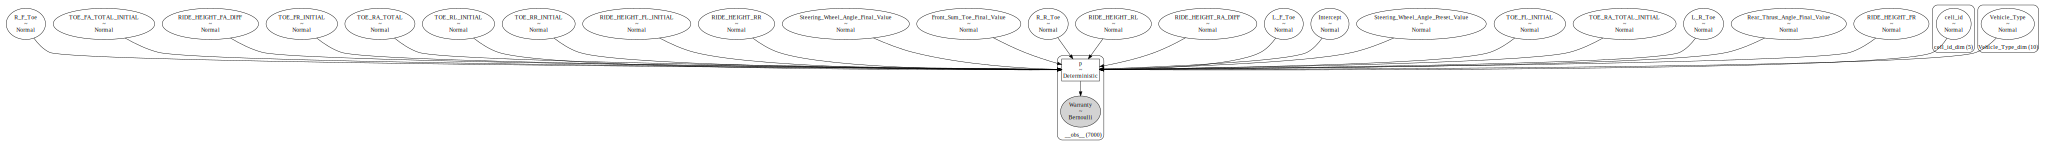

In [62]:
formula = 'Warranty ~ Rear_Thrust_Angle_Final_Value + RIDE_HEIGHT_FA_DIFF + RIDE_HEIGHT_FL_INITIAL +\
           RIDE_HEIGHT_FR + RIDE_HEIGHT_RA_DIFF + RIDE_HEIGHT_RL + RIDE_HEIGHT_RR + Steering_Wheel_Angle_Final_Value +\
           Steering_Wheel_Angle_Preset_Value + Front_Sum_Toe_Final_Value + TOE_FA_TOTAL_INITIAL + L_F_Toe +\
           TOE_FL_INITIAL + R_F_Toe + TOE_FR_INITIAL + TOE_RA_TOTAL + TOE_RA_TOTAL_INITIAL + L_R_Toe + TOE_RL_INITIAL +\
           R_R_Toe + TOE_RR_INITIAL +  cell_id+ Vehicle_Type Drive_+ Engine_+ Cab_+ CabStyle + Engine + RearWheels +\
           SteeringGear + Suspension + Tire + Transmission + Wheel + wheelbase_broadcast + LaneDeparture + MY'

modelo = bmb.Model(formula, target, family="bernoulli")
modelo.build()
modelo.graph()

In [70]:
data1 = modelo.fit(draws=2000, tune=1000, chains=4,target_accept=0.95,
                    random_seed=123,
                    idata_kwargs={"log_likelihood": True})

Output()

In [71]:
pm.summary(data1, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Front_Sum_Toe_Final_Value,-0.732,0.552,-1.806,0.352,0.008,0.006,4963.450,5532.724,1.001
Intercept,4.030,0.340,3.382,4.711,0.005,0.004,5088.512,4880.190,1.000
L_F_Toe,0.690,0.400,-0.070,1.490,0.006,0.004,5125.400,5535.065,1.001
L_R_Toe,-0.092,0.634,-1.344,1.152,0.009,0.007,4539.736,5271.600,1.001
RIDE_HEIGHT_FA_DIFF,-0.108,0.109,-0.325,0.099,0.001,0.001,13644.017,6515.714,1.000
RIDE_HEIGHT_FL_INITIAL,0.021,0.190,-0.333,0.408,0.002,0.002,9584.526,5997.227,1.000
RIDE_HEIGHT_FR,-0.127,0.199,-0.523,0.250,0.002,0.002,8850.595,5688.457,1.000
RIDE_HEIGHT_RA_DIFF,0.033,0.099,-0.160,0.225,0.001,0.001,13460.923,6491.293,1.000
RIDE_HEIGHT_RL,-0.385,0.176,-0.718,-0.034,0.002,0.002,8494.587,6461.154,1.000
RIDE_HEIGHT_RR,0.367,0.185,0.009,0.733,0.002,0.002,7896.648,6466.554,1.000


In [72]:
ll_pointwise = data1.log_likelihood["Warranty"]

In [73]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total = ll_pointwise.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat = ll_total.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat))

-580.5523174137347


In [74]:
loo = az.loo(data1)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -595.83    44.73
p_loo       29.85        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Rear_Thrust_Angle_Final_Value'}>,
        <Axes: title={'center': 'RIDE_HEIGHT_FA_DIFF'}>,
        <Axes: title={'center': 'RIDE_HEIGHT_FL_INITIAL'}>],
       [<Axes: title={'center': 'RIDE_HEIGHT_FR'}>,
        <Axes: title={'center': 'RIDE_HEIGHT_RA_DIFF'}>,
        <Axes: title={'center': 'RIDE_HEIGHT_RL'}>,
        <Axes: title={'center': 'RIDE_HEIGHT_RR'}>],
       [<Axes: title={'center': 'Steering_Wheel_Angle_Final_Value'}>,
        <Axes: title={'center': 'Steering_Wheel_Angle_Preset_Value'}>,
        <Axes: title={'center': 'Front_Sum_Toe_Final_Value'}>,
        <Axes: title={'center': 'TOE_FA_TOTAL_INITIAL'}>],
       [<Axes: title={'center': 'L_F_Toe'}>,
        <Axes: title={'center': 'TOE_FL_INITIAL'}>,
        <Axes: title={'center': 'R_F_Toe'}>,
        <Axes: title={'center': 'TOE_FR_INITIAL'}>],
       [<Axes: title={'center': 'TOE_RA_TOTAL'}>,
        <Axes: title={'center': 'TOE_RA_TOTAL_

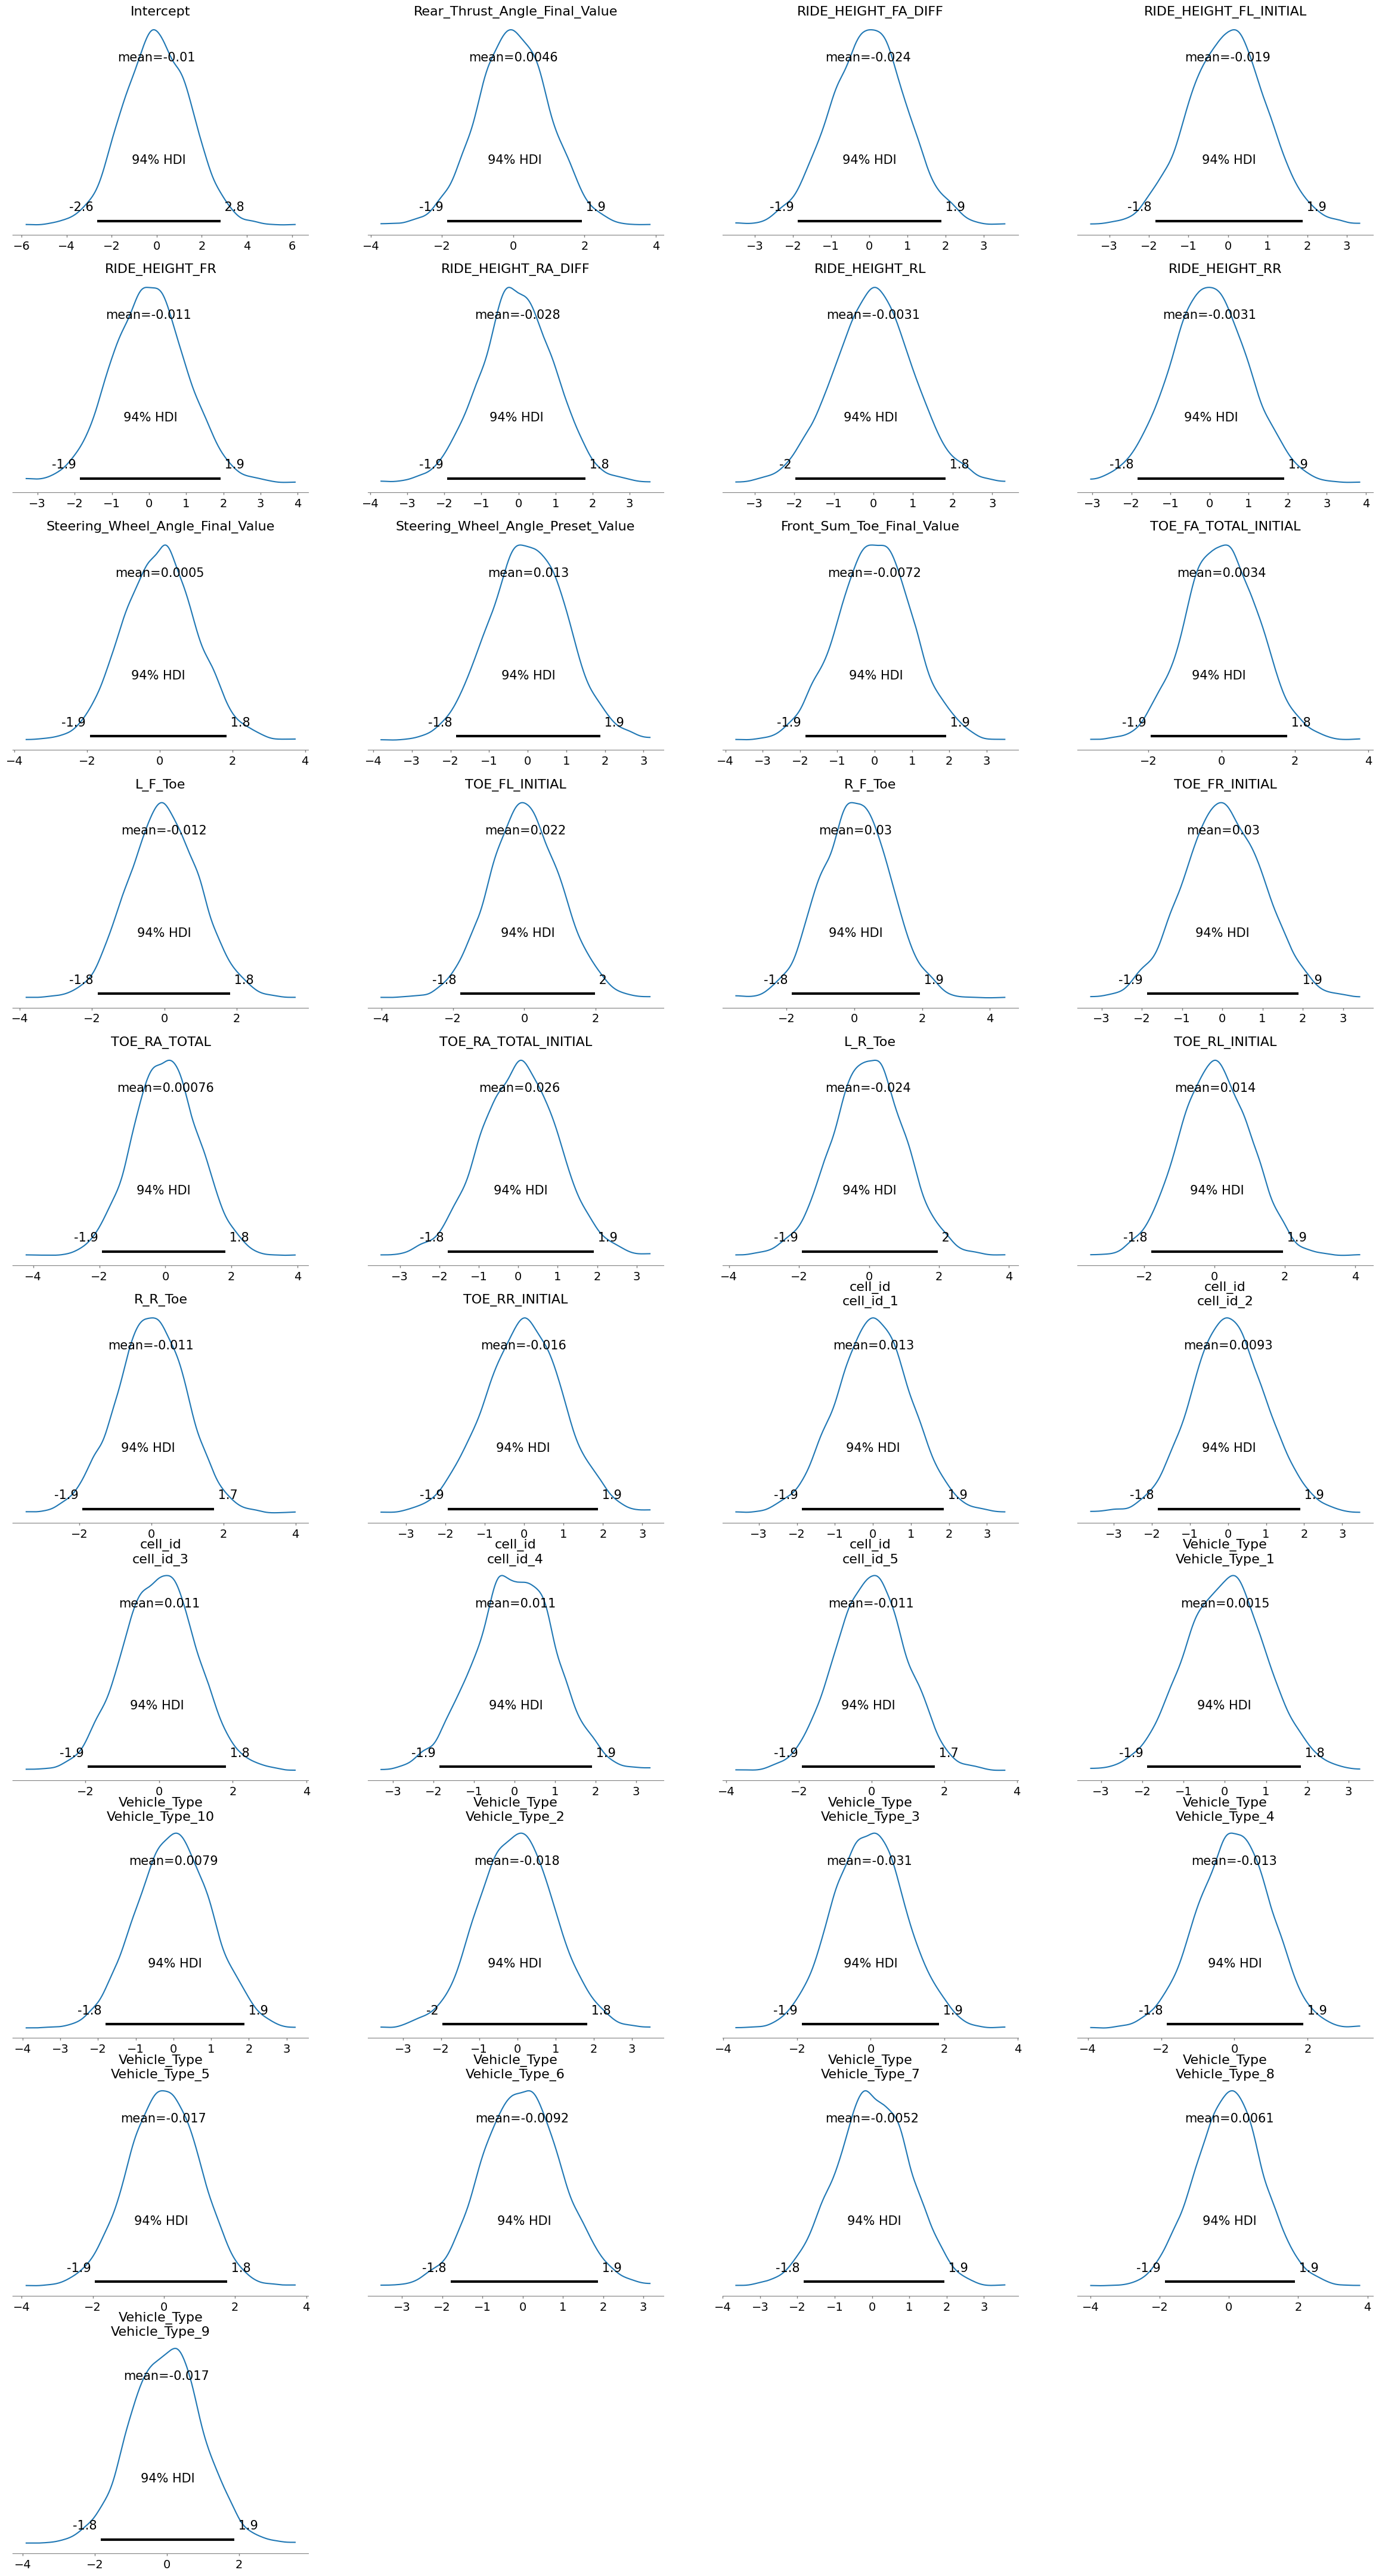

In [148]:
modelo.plot_priors()

## VIF

In [120]:
for columns in df_train[object_cols]:
  print(df_train[columns].value_counts())

cell_id
cell_id_3    2186
cell_id_4    2172
cell_id_1    1559
cell_id_5    1523
cell_id_2    1416
cell_id_0    1144
Name: count, dtype: int64
Vehicle_Type
Vehicle_Type_6     4099
Vehicle_Type_5     2408
Vehicle_Type_10     849
Vehicle_Type_7      817
Vehicle_Type_0      628
Vehicle_Type_9      598
Vehicle_Type_4      256
Vehicle_Type_3      159
Vehicle_Type_2      155
Vehicle_Type_8       29
Vehicle_Type_1        2
Name: count, dtype: int64
Warranty
Warranty_0    9833
Warranty_1     167
Name: count, dtype: int64
CabStyle
CabStyle_1    7755
CabStyle_2    1187
CabStyle_0    1058
Name: count, dtype: int64
Engine
Engine_0    3152
Engine_2    2568
Engine_3    2160
Engine_1    2120
Name: count, dtype: int64
RearWheels
RearWheels_1    8882
RearWheels_0    1118
Name: count, dtype: int64
SteeringGear
SteeringGear_2    4703
SteeringGear_3    3287
SteeringGear_1    1307
SteeringGear_0     703
Name: count, dtype: int64
Suspension
Suspension_2    6787
Suspension_1    3212
Suspension_0       1
Name:

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

def process_and_analyze_features(df_input: pd.DataFrame):
    """
    Realiza o pré-processamento de features numéricas e categóricas,
    calcula o VIF (Variance Inflation Factor) para identificar multicolinearidade
    e exibe um heatmap de correlação.

    Args:
        df_input (pd.DataFrame): O DataFrame de entrada contendo as features
                                  e a coluna 'Warranty'.

    Returns:
        tuple: Uma tupla contendo:
               - X_processed (pd.DataFrame): O DataFrame de features processadas.
               - vif_data (pd.DataFrame): O DataFrame com os resultados do VIF.
    """
    # Separar features (X) e target (y)
    X = df_input.drop('Warranty', axis=1)
    y = df_input['Warranty']

    # --- Identificar features numéricas e categóricas (usando suas listas) ---
    numerical_features_to_scale = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='category').columns.tolist()

    # --- Filtrar X para ter apenas as features que você listou ---
    all_expected_features = numerical_features_to_scale + categorical_features
    X = X[all_expected_features]

    # --- 2. Pré-processar Features Numéricas (Standard Scaling) ---
    scaler = StandardScaler()
    X_numerical_scaled_array = scaler.fit_transform(X[numerical_features_to_scale])

    # Converta o array de volta para DataFrame usando os nomes corretos
    X_numerical_processed = pd.DataFrame(X_numerical_scaled_array, columns=numerical_features_to_scale, index=X.index)

    # --- 3. Pré-processar Features Categóricas (pd.get_dummies) ---
    X_categorical_processed = pd.get_dummies(X[categorical_features], columns=categorical_features, drop_first=True)

    # --- 4. Combinar as features processadas (numéricas escaladas e categóricas dummy) ---
    X_processed = pd.concat([X_numerical_processed, X_categorical_processed], axis=1)

    # --- VERIFICAÇÕES DE SEGURANÇA E CONVERSÃO DE TIPO (CRÍTICO) ---

    # 1. Converte todas as colunas para tipo numérico, coercing erros para NaN
    X_processed = X_processed.apply(pd.to_numeric, errors='coerce')

    # 2. **NOVO PASSO CRÍTICO**: Força o DataFrame inteiro para float64
    # Isso garante que todas as colunas tenham um dtype numérico adequado para operações NumPy
    X_processed = X_processed.astype(np.float64)

    # 3. Verifica e lida com NaN (se algum foi introduzido por 'coerce' ou por problemas do scaler)
    if X_processed.isnull().sum().sum() > 0:
        print("AVISO: NaNs encontrados nos dados processados após conversão. Preenchendo com a média da coluna.")
        # Preencher NaNs com a média da coluna
        X_processed = X_processed.fillna(X_processed.mean())
        # Se uma coluna inteira for NaN (e.g., se to_numeric resultou em NaN para toda a coluna),
        # a média também será NaN. Preenche com 0 nesses casos.
        X_processed = X_processed.fillna(0)

    # 4. Verifica e lida com Infinitos (se algum foi introduzido pelo scaler)
    if np.isinf(X_processed.values).sum() > 0:
        print("AVISO: Infs encontrados nos dados processados. Substituindo por NaN e depois preenchendo com 0.")
        X_processed = X_processed.replace([np.inf, -np.inf], np.nan).fillna(0)

    #print(f"Dtypes dos dados processados DEPOIS da limpeza:\n{X_processed.dtypes}\n")

    # --- 5. Calcular o VIF para cada feature ---
    # Adiciona uma constante (intercepto) ao DataFrame para o cálculo do VIF
    X_processed_with_const = sm.add_constant(X_processed, has_constant='add')

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_processed_with_const.columns
    # Não precisa mais do .astype(np.float64) aqui, pois já foi feito acima
    vif_data["VIF"] = [variance_inflation_factor(X_processed_with_const.values, i)
                       for i in range(X_processed_with_const.shape[1])]

    # Remover a linha da constante do VIF
    vif_data = vif_data[vif_data['feature'] != 'const']

    # Classificar para facilitar a visualização
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

    print("\nResultados do VIF:")
    print(vif_data)

    # --- 6. Interpretação (Exemplo) ---
    print("\n--- Interpretação ---")
    high_vif_features = vif_data[vif_data['VIF'] >= 3]
    if not high_vif_features.empty:
        print("\nFeatures com alta multicolinearidade (VIF >= 3):")
        print(high_vif_features)
        print("\nConsidere remover ou combinar essas features para melhorar a estabilidade do modelo.")
    else:
        print("\nNenhuma feature com alta multicolinearidade (VIF >= 3) encontrada.")

    # --- 7. Outros métodos visuais (complementares) ---
    plt.figure(figsize=(15, 12))
    sns.heatmap(X_processed.corr(), cmap='coolwarm', linewidths=.1, linecolor='lightgray', square=True)
    plt.title('Matriz de Correlação das Features Processadas')
    plt.show()

    return X_processed, vif_data


Resultados do VIF:
                              feature          VIF
0                             R_R_Toe  3692.352518
1                             L_R_Toe  3646.172888
2             Suspension_Suspension_2  2192.490863
3             Suspension_Suspension_1  2192.262567
4                        TOE_RA_TOTAL  2048.631373
5                      TOE_FL_INITIAL   337.849606
6                      TOE_FR_INITIAL   217.278625
7                TOE_FA_TOTAL_INITIAL   195.514914
8           Front_Sum_Toe_Final_Value    80.774269
9                             L_F_Toe    41.541403
10                            R_F_Toe    38.823929
11               TOE_RA_TOTAL_INITIAL    34.899693
12                     TOE_RL_INITIAL    33.069062
13                     TOE_RR_INITIAL    28.174372
14                     RIDE_HEIGHT_FL    17.562374
15                     RIDE_HEIGHT_FR    12.068055
16                        Tire_Tire_6     9.906409
17                        Tire_Tire_7     8.219695
18         

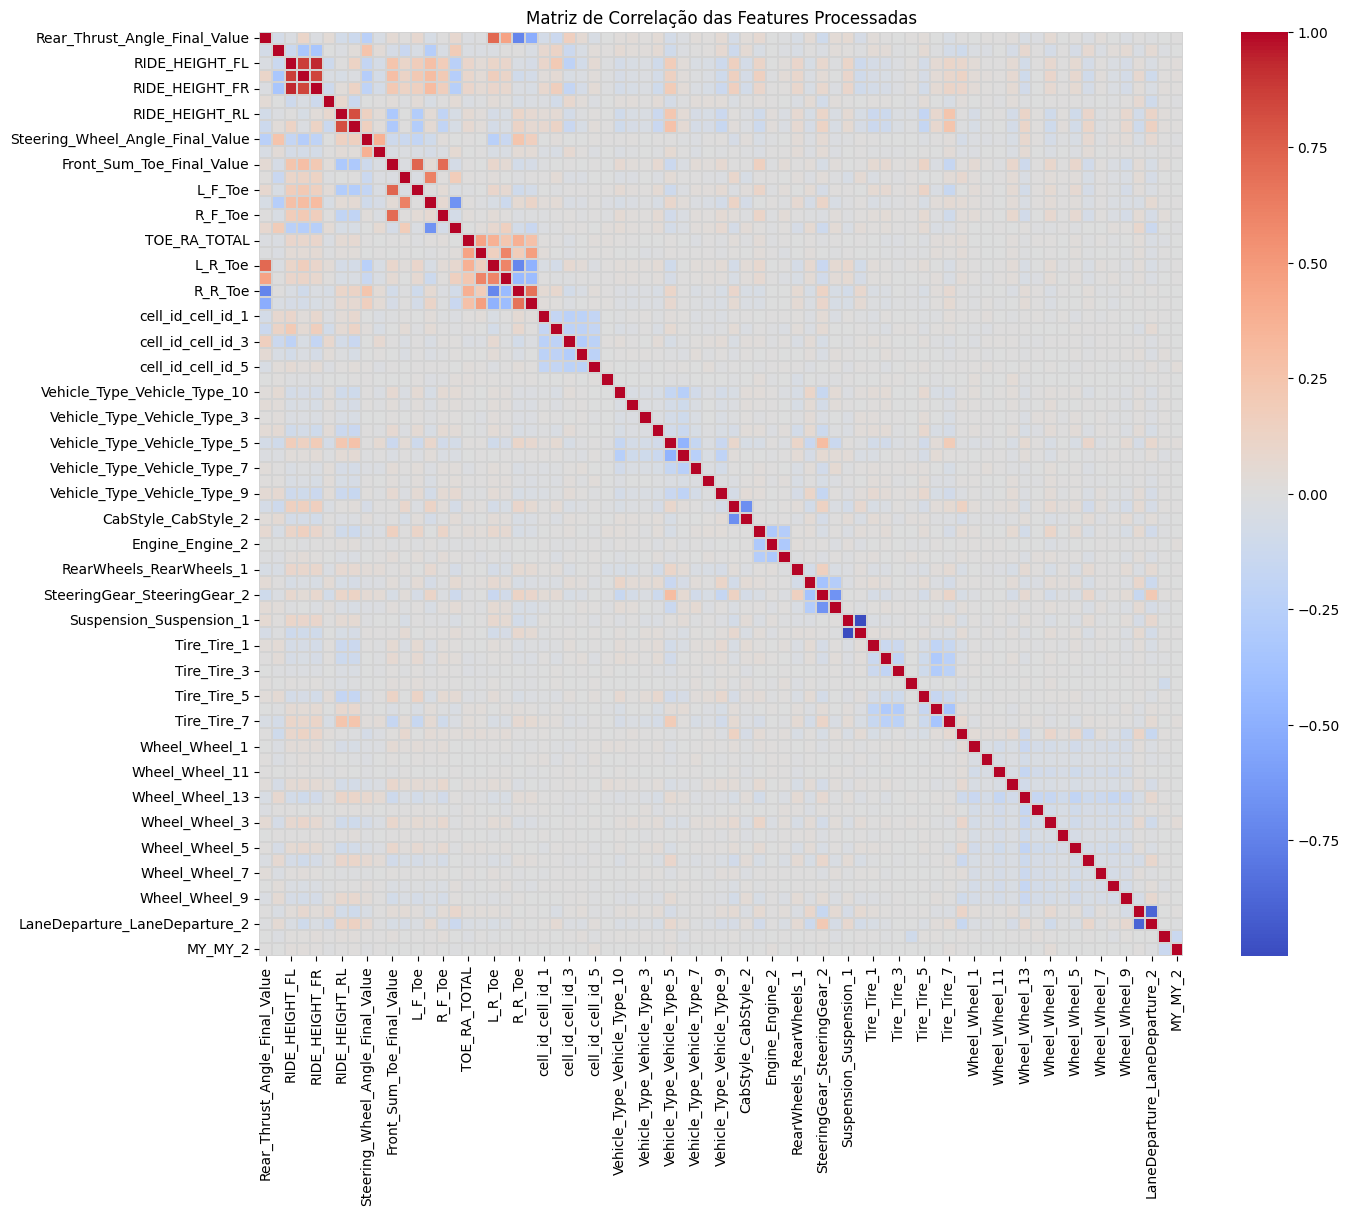

In [55]:
check_multi = process_and_analyze_features(df_train)

In [79]:
df_train.columns

Index(['cell_id', 'Vehicle_Type', 'Warranty', 'Rear_Thrust_Angle_Final_Value',
       'RIDE_HEIGHT_FA_DIFF', 'RIDE_HEIGHT_FL', 'RIDE_HEIGHT_FL_INITIAL',
       'RIDE_HEIGHT_FR', 'RIDE_HEIGHT_RA_DIFF', 'RIDE_HEIGHT_RL',
       'RIDE_HEIGHT_RR', 'Steering_Wheel_Angle_Final_Value',
       'Steering_Wheel_Angle_Preset_Value', 'Front_Sum_Toe_Final_Value',
       'TOE_FA_TOTAL_INITIAL', 'L_F_Toe', 'TOE_FL_INITIAL', 'R_F_Toe',
       'TOE_FR_INITIAL', 'TOE_RA_TOTAL', 'TOE_RA_TOTAL_INITIAL', 'L_R_Toe',
       'TOE_RL_INITIAL', 'R_R_Toe', 'TOE_RR_INITIAL', 'CabStyle', 'Engine',
       'RearWheels', 'SteeringGear', 'Suspension', 'Tire', 'Transmission',
       'Wheel', 'LaneDeparture', 'MY'],
      dtype='object')

In [56]:
filtered_columns_for_vif = [
    'Warranty', # variável target
    # Vamos listar apenas as preditoras para o X.

    # Features Numéricas
    'Rear_Thrust_Angle_Final_Value',
    'RIDE_HEIGHT_FA_DIFF',
    'RIDE_HEIGHT_RA_DIFF',
    'RIDE_HEIGHT_RL',
    'RIDE_HEIGHT_RR',
    'Steering_Wheel_Angle_Final_Value',
    'Steering_Wheel_Angle_Preset_Value',
    'TOE_RA_TOTAL', # Mantida, mas será crucial observar seu VIF novamente

    # Features Categóricas (serão expandidas por pd.get_dummies)
    'cell_id',
    'CabStyle',
    'Engine',
    'RearWheels',
    'SteeringGear',
    'Suspension', # Mantida, pd.get_dummies(drop_first=True) deve resolver o VIF alto de seus dummies
    'Tire',
    'Transmission',
    'Wheel',
    'LaneDeparture',
    'Vehicle_Type', # Mantida (efeito aleatório no modelo, mas tratada como fixa para VIF)
    'MY'            # Mantida (efeito aleatório no modelo, mas tratada como fixa para VIF)
]

X_for_vif = df_train[filtered_columns_for_vif].copy()

In [57]:
X_for_vif.columns

Index(['Warranty', 'Rear_Thrust_Angle_Final_Value', 'RIDE_HEIGHT_FA_DIFF',
       'RIDE_HEIGHT_RA_DIFF', 'RIDE_HEIGHT_RL', 'RIDE_HEIGHT_RR',
       'Steering_Wheel_Angle_Final_Value', 'Steering_Wheel_Angle_Preset_Value',
       'TOE_RA_TOTAL', 'cell_id', 'CabStyle', 'Engine', 'RearWheels',
       'SteeringGear', 'Suspension', 'Tire', 'Transmission', 'Wheel',
       'LaneDeparture', 'Vehicle_Type', 'MY'],
      dtype='object')


Resultados do VIF:
                              feature          VIF
0             Suspension_Suspension_2  2190.445971
1             Suspension_Suspension_1  2190.272301
2                         Tire_Tire_6     9.869063
3                         Tire_Tire_7     8.150011
4                         Tire_Tire_2     6.742238
5                         Tire_Tire_3     6.490038
6         SteeringGear_SteeringGear_2     5.225472
7       LaneDeparture_LaneDeparture_2     4.978818
8       LaneDeparture_LaneDeparture_1     4.664588
9         Vehicle_Type_Vehicle_Type_6     4.558210
10                     Wheel_Wheel_13     4.429158
11        SteeringGear_SteeringGear_3     4.310370
12                        Tire_Tire_1     4.062425
13        Vehicle_Type_Vehicle_Type_5     4.046661
14                     RIDE_HEIGHT_RR     3.734690
15                     RIDE_HEIGHT_RL     3.592361
16                        Tire_Tire_5     3.057726
17                      Wheel_Wheel_5     2.683431
18        S

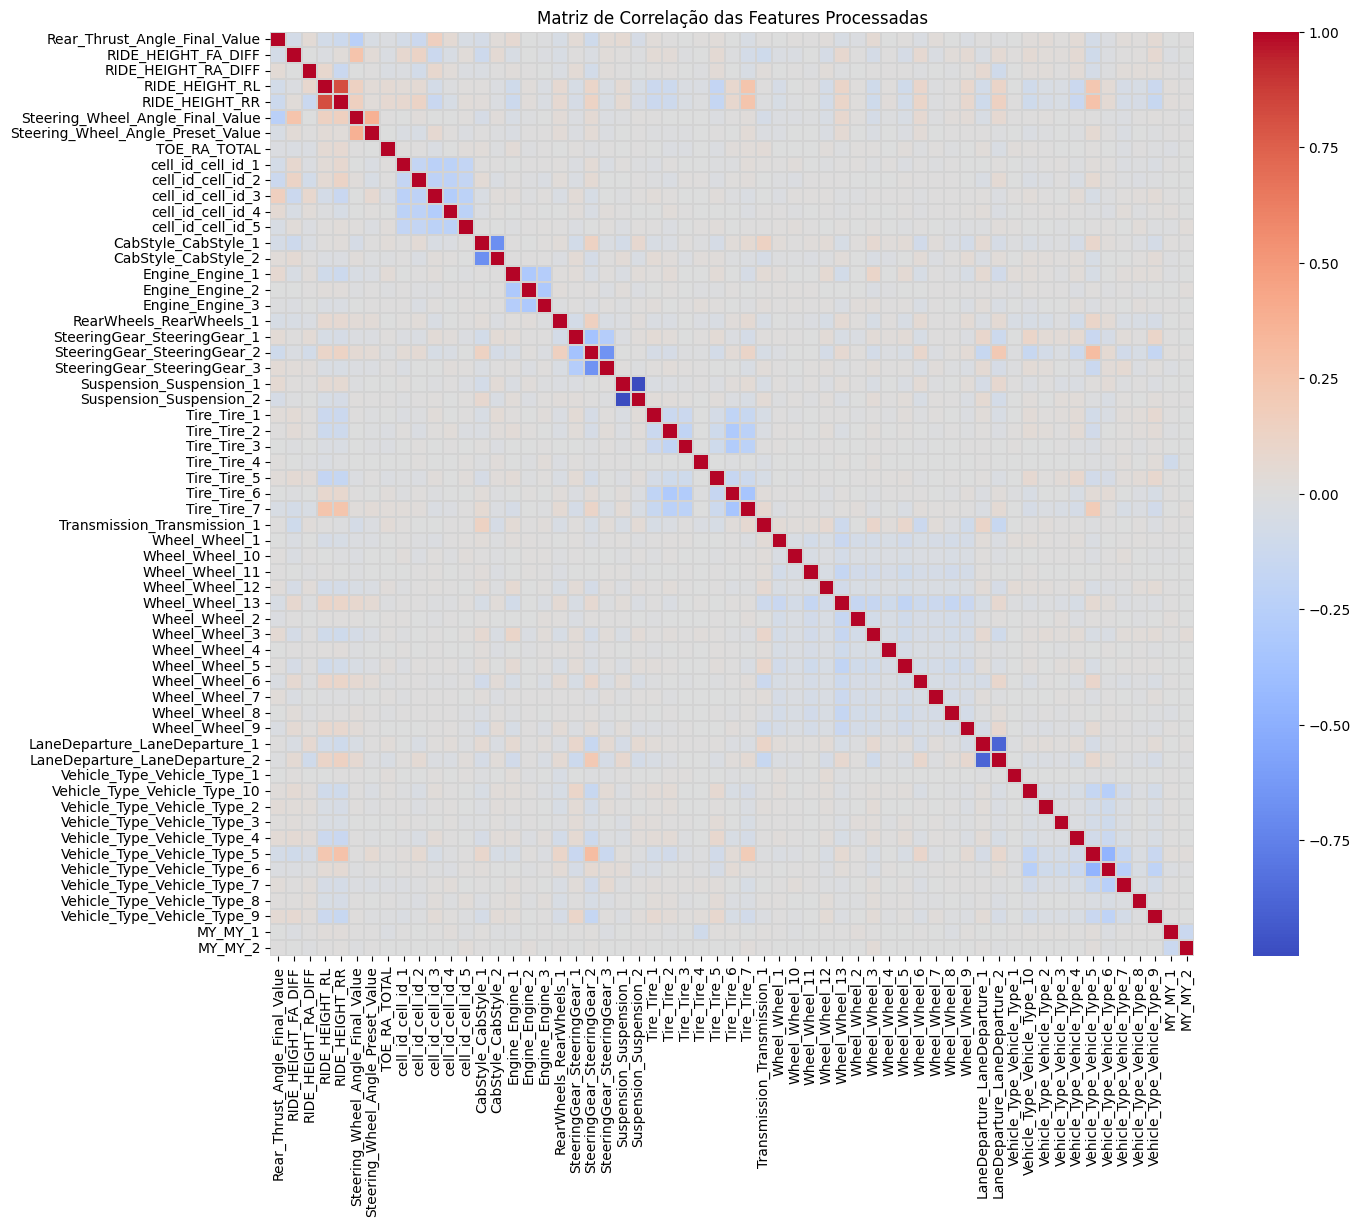

In [132]:
check_multi = process_and_analyze_features(X_for_vif)

In [133]:
X_for_vif.columns

Index(['Warranty', 'Rear_Thrust_Angle_Final_Value', 'RIDE_HEIGHT_FA_DIFF',
       'RIDE_HEIGHT_RA_DIFF', 'RIDE_HEIGHT_RL', 'RIDE_HEIGHT_RR',
       'Steering_Wheel_Angle_Final_Value', 'Steering_Wheel_Angle_Preset_Value',
       'TOE_RA_TOTAL', 'cell_id', 'CabStyle', 'Engine', 'RearWheels',
       'SteeringGear', 'Suspension', 'Tire', 'Transmission', 'Wheel',
       'LaneDeparture', 'Vehicle_Type', 'MY'],
      dtype='object')

## Base sem multicolineriedade

In [112]:
X_for_vif.columns

Index(['Warranty', 'Rear_Thrust_Angle_Final_Value', 'RIDE_HEIGHT_FA_DIFF',
       'RIDE_HEIGHT_RA_DIFF', 'RIDE_HEIGHT_RL', 'RIDE_HEIGHT_RR',
       'Steering_Wheel_Angle_Final_Value', 'Steering_Wheel_Angle_Preset_Value',
       'TOE_RA_TOTAL', 'cell_id', 'CabStyle', 'Engine', 'RearWheels',
       'SteeringGear', 'Suspension', 'Tire', 'Transmission', 'Wheel',
       'LaneDeparture', 'Vehicle_Type', 'MY'],
      dtype='object')

In [113]:
target_vif = target[['Warranty', 'Rear_Thrust_Angle_Final_Value', 'RIDE_HEIGHT_FA_DIFF',
       'RIDE_HEIGHT_RA_DIFF', 'RIDE_HEIGHT_RL', 'RIDE_HEIGHT_RR',
       'Steering_Wheel_Angle_Final_Value', 'Steering_Wheel_Angle_Preset_Value',
       'TOE_RA_TOTAL', 'cell_id', 'CabStyle', 'Engine', 'RearWheels',
       'SteeringGear', 'Suspension', 'Tire', 'Transmission', 'Wheel',
       'LaneDeparture', 'Vehicle_Type', 'MY']]

In [114]:
formula_vif2 = 'Warranty ~ Rear_Thrust_Angle_Final_Value +  RIDE_HEIGHT_FA_DIFF +\
        RIDE_HEIGHT_RA_DIFF +  RIDE_HEIGHT_RL +  RIDE_HEIGHT_RR +\
        Steering_Wheel_Angle_Final_Value +  Steering_Wheel_Angle_Preset_Value +\
        TOE_RA_TOTAL +  cell_id +  CabStyle +  Engine +  RearWheels +\
        SteeringGear +  Suspension +  Tire +  Transmission +  Wheel +\
        LaneDeparture +  Vehicle_Type +  MY'

modelo_sem_vif2 = bmb.Model(formula_vif2, target_vif, family="bernoulli")

In [ ]:
#print(modelo)

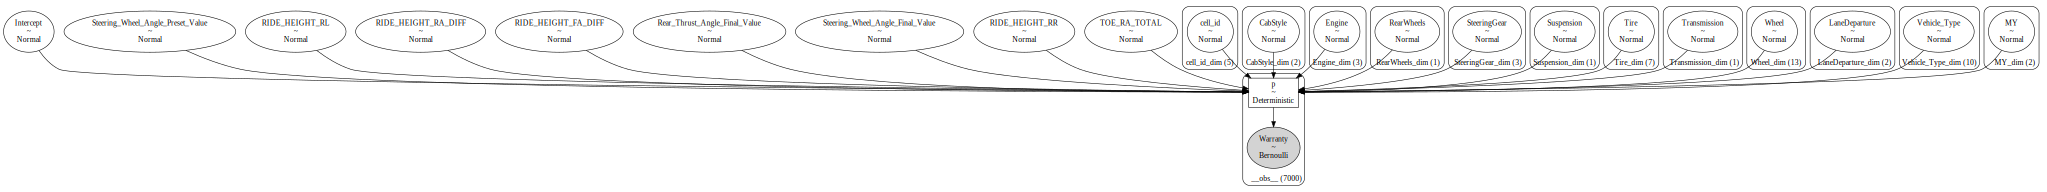

In [116]:
modelo_sem_vif2.build()
modelo_sem_vif2.graph()

In [117]:
data1_sem_vif2 = modelo_sem_vif2.fit(draws=2000, tune=1000, chains=4,target_accept=0.95,
                    random_seed=123,
                    idata_kwargs={"log_likelihood": True})

Output()

In [118]:
pm.summary(data1_sem_vif2, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CabStyle[CabStyle_1],-0.164,0.304,-0.751,0.446,0.004,0.003,6401.857,5241.851,1.001
CabStyle[CabStyle_2],0.304,0.412,-0.500,1.096,0.005,0.004,6514.563,5836.627,1.000
Engine[Engine_1],0.008,0.262,-0.467,0.566,0.003,0.003,7161.033,6162.542,1.001
Engine[Engine_2],0.258,0.265,-0.245,0.796,0.003,0.003,6208.758,5642.937,1.001
Engine[Engine_3],-0.050,0.249,-0.549,0.424,0.003,0.003,6633.544,5774.267,1.001
Intercept,5.064,1.164,2.869,7.366,0.015,0.012,5953.551,5392.571,1.000
LaneDeparture[LaneDeparture_1],0.365,0.333,-0.292,1.005,0.005,0.004,4866.173,4843.702,1.000
LaneDeparture[LaneDeparture_2],0.438,0.332,-0.226,1.075,0.005,0.004,4707.123,5042.192,1.000
MY[MY_1],-0.516,0.830,-2.122,1.112,0.009,0.009,9185.671,5849.976,1.000
MY[MY_2],0.020,0.994,-1.900,1.997,0.010,0.011,10237.935,6273.869,1.000


In [119]:
ll_pointwise_sem_vif2 = data1_sem_vif2.log_likelihood["Warranty"]

In [ ]:
#z.plot_trace(data1)

In [120]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total_sem_vif2 = ll_pointwise_sem_vif2.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat_sem_vif2 = ll_total_sem_vif2.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat_sem_vif2))



-576.64150112653


In [121]:
loo = az.loo(data1_sem_vif2)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -600.92    45.38
p_loo       46.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Multinivel VT

In [151]:
formula_multi = 'Warranty ~ TOE_RA_TOTAL + RIDE_HEIGHT_RA_DIFF + ' \
          'LaneDeparture + SteeringGear + Wheel + ' \
          '(1|Vehicle_Type)'

modelo_multi = bmb.Model(formula_multi, target, family="bernoulli")

In [ ]:
#print(modelo)

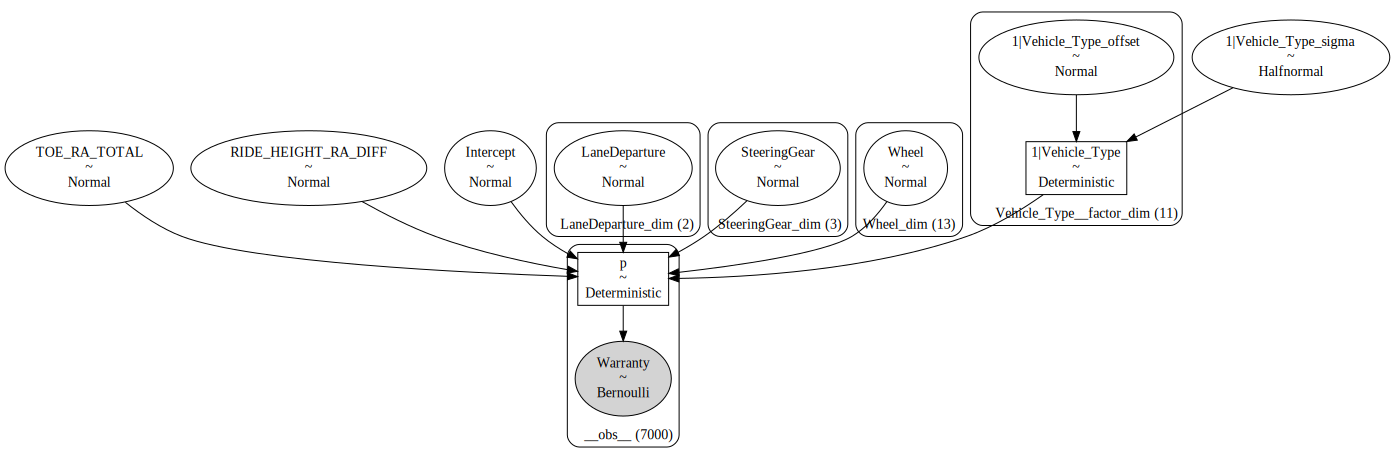

In [152]:
modelo_multi.build()
modelo_multi.graph()

In [153]:
data1_multi = modelo_multi.fit(draws=2000, tune=1000, chains=4,target_accept=0.99,
                    random_seed=123,
                    idata_kwargs={"log_likelihood": True})

Output()

In [154]:
pm.summary(data1_multi, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|Vehicle_Type[Vehicle_Type_0],-0.019,0.145,-0.355,0.271,0.002,0.002,9898.379,6878.897,1.000
1|Vehicle_Type[Vehicle_Type_1],0.004,0.187,-0.354,0.433,0.002,0.005,9261.042,6574.071,1.002
1|Vehicle_Type[Vehicle_Type_10],0.061,0.159,-0.206,0.438,0.002,0.003,6858.591,6953.195,1.001
1|Vehicle_Type[Vehicle_Type_2],-0.031,0.170,-0.451,0.278,0.002,0.003,9433.551,7150.672,1.000
1|Vehicle_Type[Vehicle_Type_3],0.005,0.169,-0.376,0.352,0.002,0.003,9267.799,6930.018,1.000
1|Vehicle_Type[Vehicle_Type_4],-0.016,0.159,-0.377,0.317,0.002,0.003,9355.780,6909.113,1.000
1|Vehicle_Type[Vehicle_Type_5],-0.005,0.128,-0.292,0.261,0.002,0.002,7208.879,5678.243,1.001
1|Vehicle_Type[Vehicle_Type_6],0.041,0.123,-0.191,0.321,0.002,0.002,6037.212,5963.218,1.000
1|Vehicle_Type[Vehicle_Type_7],0.022,0.145,-0.274,0.334,0.002,0.003,9389.049,6672.246,1.000
1|Vehicle_Type[Vehicle_Type_8],0.012,0.183,-0.348,0.391,0.002,0.004,9727.297,6693.571,1.002


In [155]:
ll_pointwise_multi = data1_multi.log_likelihood["Warranty"]

In [ ]:
#z.plot_trace(data1)

In [156]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total_multi = ll_pointwise_multi.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat_multi = ll_total_multi.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat_multi))



-577.4259389923849


In [157]:
loo = az.loo(data1_multi)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -587.08    43.93
p_loo       18.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Multinivel Pit

In [18]:
formula_multi_2 = 'Warranty ~ TOE_RA_TOTAL + RIDE_HEIGHT_RA_DIFF + ' \
          'LaneDeparture + SteeringGear + Wheel + ' \
          '(1|cell_id)'

modelo_multi_2 = bmb.Model(formula_multi_2, target, family="bernoulli")

In [19]:
#print(modelo)

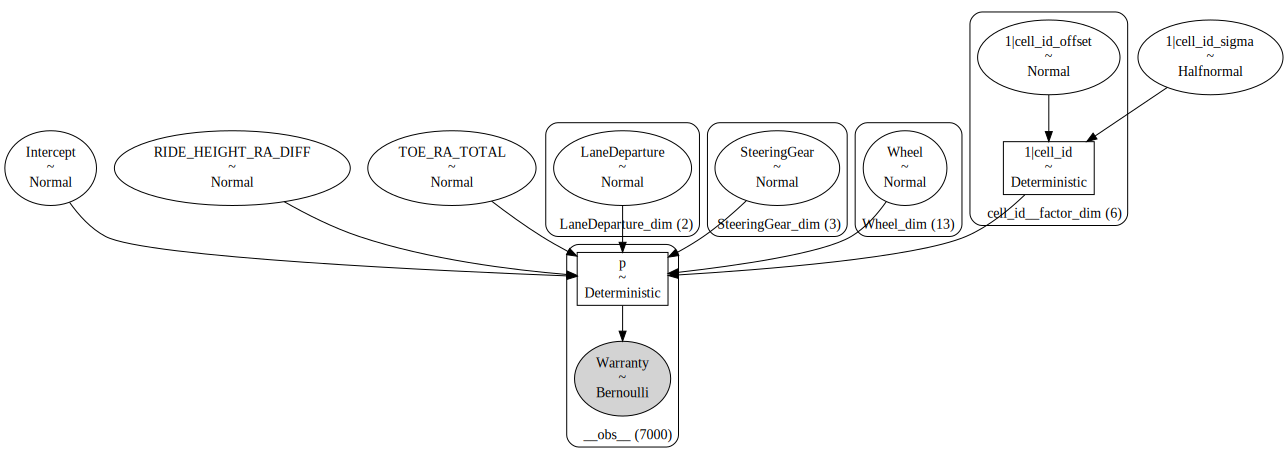

In [20]:
modelo_multi_2.build()
modelo_multi_2.graph()

In [37]:
data1_multi_2 = modelo_multi_2.fit(draws=2000, tune=1000, chains=4,target_accept=0.999,
                    random_seed=123, max_treedepth=25,
                    idata_kwargs={"log_likelihood": True})

Output()

In [38]:
pm.summary(data1_multi_2, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|cell_id[cell_id_0],-0.033,0.146,-0.358,0.243,0.002,0.006,7949.596,5554.951,1.000
1|cell_id[cell_id_1],0.059,0.157,-0.202,0.412,0.003,0.008,5202.158,4733.218,1.001
1|cell_id[cell_id_2],0.056,0.161,-0.215,0.420,0.003,0.008,6098.420,4160.792,1.001
1|cell_id[cell_id_3],-0.005,0.138,-0.319,0.253,0.002,0.008,7031.459,4917.461,1.000
1|cell_id[cell_id_4],0.014,0.139,-0.267,0.307,0.003,0.008,5846.422,3923.329,1.000
1|cell_id[cell_id_5],-0.019,0.143,-0.350,0.242,0.002,0.007,6458.765,4608.453,1.000
1|cell_id_sigma,0.147,0.152,0.000,0.406,0.003,0.011,3779.718,4293.345,1.001
Intercept,4.227,0.480,3.284,5.158,0.008,0.005,4063.539,5419.961,1.000
LaneDeparture[LaneDeparture_1],0.339,0.326,-0.258,1.003,0.004,0.003,5432.341,5873.660,1.000
LaneDeparture[LaneDeparture_2],0.385,0.322,-0.238,1.026,0.004,0.003,5684.519,5463.118,1.000


In [39]:
ll_pointwise_multi_2 = data1_multi_2.log_likelihood["Warranty"]

In [24]:
#z.plot_trace(data1)

In [40]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total_multi_2 = ll_pointwise_multi_2.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat_multi_2 = ll_total_multi_2.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat_multi_2))



-577.3399092095476


In [41]:
loo = az.loo(data1_multi_2)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -586.93    43.94
p_loo       18.68        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Multinivel SG

In [42]:
formula_multi_sg = 'Warranty ~ RIDE_HEIGHT_RL + Steering_Wheel_Angle_Final_Value + RIDE_HEIGHT_RA_DIFF + \
                  RIDE_HEIGHT_RR + Wheel + (1|SteeringGear)'

modelo_multi_sg = bmb.Model(formula_multi_sg, target, family="bernoulli")

In [28]:
#print(modelo)

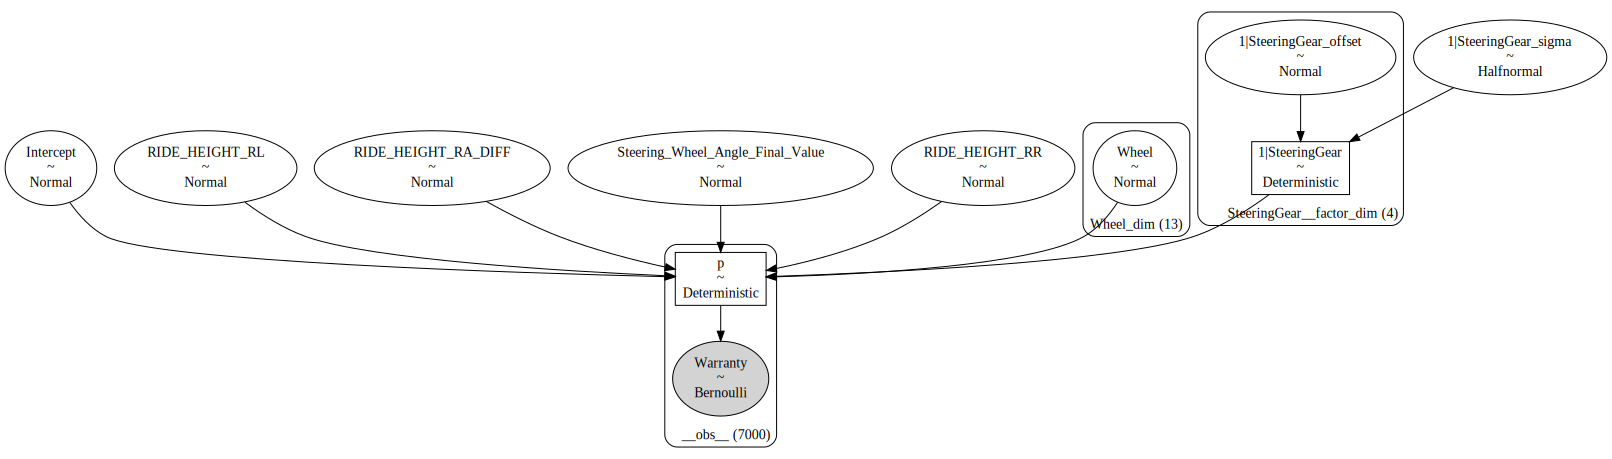

In [43]:
modelo_multi_sg.build()
modelo_multi_sg.graph()

In [44]:
data1_multi_sg = modelo_multi_sg.fit(draws=2000, tune=1000, chains=4,target_accept=0.999,
                    random_seed=123, max_treedepth=25,
                    idata_kwargs={"log_likelihood": True})

Output()

In [49]:
pm.summary(data1_multi_sg, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|SteeringGear[SteeringGear_0],0.478,0.733,-0.455,2.044,0.025,0.038,1215.772,1010.018,1.003
1|SteeringGear[SteeringGear_1],-0.032,0.577,-0.970,1.212,0.019,0.035,1445.224,952.383,1.003
1|SteeringGear[SteeringGear_2],0.325,0.611,-0.450,1.697,0.022,0.037,1267.853,938.067,1.003
1|SteeringGear[SteeringGear_3],0.246,0.604,-0.591,1.568,0.021,0.037,1325.571,929.041,1.003
1|SteeringGear_sigma,0.602,0.703,0.000,2.068,0.024,0.034,1071.557,1216.384,1.004
Intercept,3.935,0.638,2.506,4.852,0.022,0.034,1220.613,903.060,1.004
RIDE_HEIGHT_RA_DIFF,0.039,0.101,-0.159,0.238,0.001,0.001,7306.667,6039.680,1.000
RIDE_HEIGHT_RL,-0.411,0.172,-0.736,-0.064,0.003,0.002,4541.103,5577.730,1.000
RIDE_HEIGHT_RR,0.327,0.177,-0.023,0.673,0.003,0.002,4604.109,5663.093,1.000
Steering_Wheel_Angle_Final_Value,0.000,0.093,-0.184,0.181,0.001,0.001,8441.483,5850.159,1.001


In [50]:
ll_pointwise_multi_sg = data1_multi_sg.log_likelihood["Warranty"]

In [33]:
#z.plot_trace(data1)

In [51]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total_multi_sg = ll_pointwise_multi_sg.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat_multi_sg = ll_total_multi_sg.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat_multi_sg))



-577.8132859061468


In [52]:
loo = az.loo(data1_multi_sg)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -586.75    43.86
p_loo       17.39        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Multinivel Wheel

In [76]:
formula_wheel = 'Warranty ~ TOE_RA_TOTAL + RIDE_HEIGHT_RA_DIFF + SteeringGear + (1|Wheel)'

modelo_wheel = bmb.Model(formula_wheel, target, family="bernoulli")

In [ ]:
#print(modelo)

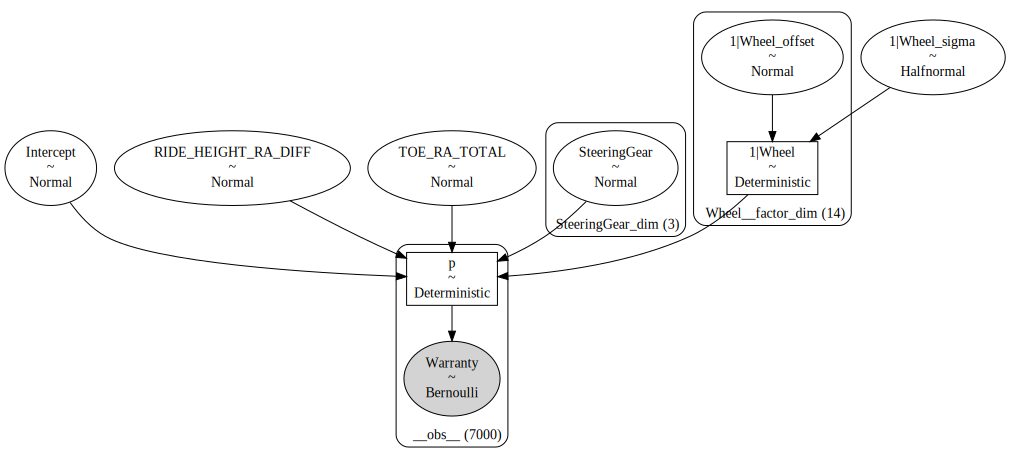

In [77]:
modelo_wheel.build()
modelo_wheel.graph()

In [78]:
data1_wheel = modelo_wheel.fit(draws=2000, tune=1000, chains=4,target_accept=0.95,
                    random_seed=123,
                    idata_kwargs={"log_likelihood": True})

Output()

In [79]:
pm.summary(data1_wheel, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|Wheel[Wheel_0],0.021,0.201,-0.405,0.450,0.002,0.003,9536.675,6521.092,1.001
1|Wheel[Wheel_1],-0.074,0.192,-0.484,0.308,0.002,0.003,7832.209,6395.876,1.000
1|Wheel[Wheel_10],0.112,0.265,-0.331,0.742,0.003,0.005,7095.139,5753.065,1.000
1|Wheel[Wheel_11],0.033,0.188,-0.369,0.415,0.002,0.003,9841.299,6748.636,1.000
1|Wheel[Wheel_12],0.054,0.239,-0.413,0.576,0.003,0.005,8304.806,6351.738,1.000
1|Wheel[Wheel_13],0.170,0.193,-0.127,0.595,0.003,0.002,4442.729,6014.639,1.000
1|Wheel[Wheel_2],0.016,0.185,-0.366,0.423,0.002,0.003,8905.278,6738.818,1.000
1|Wheel[Wheel_3],-0.146,0.205,-0.587,0.206,0.003,0.002,5409.720,6108.879,1.000
1|Wheel[Wheel_4],-0.122,0.229,-0.626,0.294,0.003,0.003,6625.345,6810.857,1.000
1|Wheel[Wheel_5],0.053,0.183,-0.312,0.454,0.002,0.003,8320.422,6573.978,1.000


In [80]:
ll_pointwise_wheel = data1_wheel.log_likelihood["Warranty"]

In [ ]:
#z.plot_trace(data1)

In [81]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total_wheel = ll_pointwise_wheel.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat_wheel = ll_total_wheel.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat_wheel))



-578.5310544274315


In [82]:
loo = az.loo(data1_wheel)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -583.25    43.44
p_loo        9.36        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Multinivel Wheel 2

In [96]:
formula_wheel = 'Warranty ~ TOE_RA_TOTAL + (1|Wheel)'

modelo_wheel = bmb.Model(formula_wheel, target, family="bernoulli")

In [ ]:
#print(modelo)

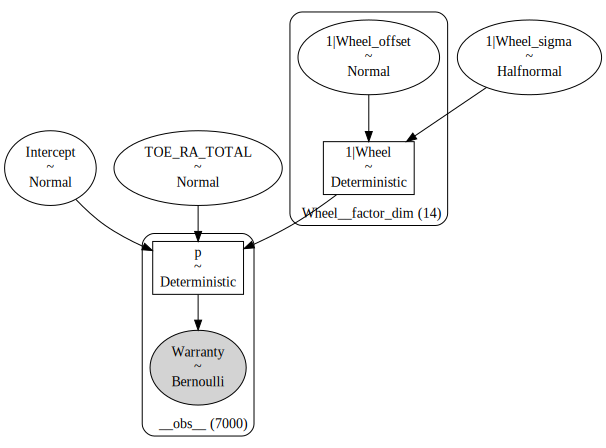

In [97]:
modelo_wheel.build()
modelo_wheel.graph()

In [98]:
data1_wheel = modelo_wheel.fit(draws=2000, tune=1000, chains=4,target_accept=0.999,
                    random_seed=123,max_treedepth=25,
                    idata_kwargs={"log_likelihood": True})

Output()

In [99]:
pm.summary(data1_wheel, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|Wheel[Wheel_0],0.018,0.207,-0.408,0.464,0.002,0.003,10894.104,6261.731,1.001
1|Wheel[Wheel_1],-0.083,0.197,-0.508,0.297,0.002,0.003,7958.289,6388.143,1.001
1|Wheel[Wheel_10],0.113,0.269,-0.377,0.692,0.003,0.005,7288.663,5627.848,1.001
1|Wheel[Wheel_11],0.035,0.186,-0.339,0.431,0.002,0.002,8567.313,6823.109,1.001
1|Wheel[Wheel_12],0.044,0.231,-0.402,0.546,0.003,0.004,8898.340,5888.371,1.002
1|Wheel[Wheel_13],0.181,0.197,-0.131,0.606,0.003,0.002,5171.509,6307.973,1.001
1|Wheel[Wheel_2],0.019,0.190,-0.373,0.429,0.002,0.003,10112.901,6878.645,1.001
1|Wheel[Wheel_3],-0.157,0.210,-0.630,0.180,0.003,0.003,5921.662,6471.740,1.001
1|Wheel[Wheel_4],-0.129,0.235,-0.675,0.255,0.003,0.003,6358.157,6119.432,1.000
1|Wheel[Wheel_5],0.053,0.186,-0.315,0.466,0.002,0.003,7398.989,6727.866,1.001


In [100]:
ll_pointwise_wheel = data1_wheel.log_likelihood["Warranty"]

In [ ]:
#z.plot_trace(data1)

In [101]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total_wheel = ll_pointwise_wheel.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat_wheel = ll_total_wheel.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat_wheel))



-579.4230793927134


In [102]:
loo = az.loo(data1_wheel)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -582.43    43.33
p_loo        6.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Classico Toe e Wheel

In [103]:
formula_wheel_toe = 'Warranty ~ TOE_RA_TOTAL + Wheel'

modelo_wheel_toe = bmb.Model(formula_wheel_toe, target, family="bernoulli")

In [ ]:
#print(modelo)

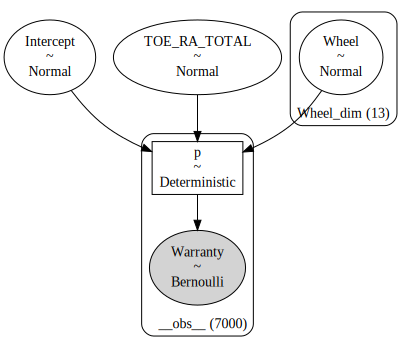

In [105]:
modelo_wheel_toe.build()
modelo_wheel_toe.graph()

In [106]:
data1_wheel_toe = modelo_wheel_toe.fit(draws=2000, tune=1000, chains=4,target_accept=0.95,
                    random_seed=123,
                    idata_kwargs={"log_likelihood": True})

Output()

In [107]:
pm.summary(data1_wheel_toe, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.174,0.247,3.690,4.666,0.004,0.003,3241.996,4035.384,1.001
TOE_RA_TOTAL,-0.204,0.093,-0.377,-0.019,0.001,0.001,8023.239,6184.368,1.000
Wheel[Wheel_1],-0.320,0.386,-1.063,0.441,0.006,0.004,4895.678,5625.891,1.001
Wheel[Wheel_10],0.944,0.741,-0.443,2.400,0.008,0.008,8600.094,5800.604,1.000
Wheel[Wheel_11],0.042,0.388,-0.724,0.805,0.005,0.004,5454.976,5701.742,1.000
Wheel[Wheel_12],0.237,0.590,-0.907,1.384,0.007,0.006,7247.462,5564.353,1.000
Wheel[Wheel_13],0.300,0.322,-0.346,0.897,0.005,0.004,4234.972,4680.988,1.001
Wheel[Wheel_2],-0.015,0.388,-0.749,0.766,0.005,0.004,5469.055,5671.278,1.000
Wheel[Wheel_3],-0.499,0.356,-1.192,0.197,0.005,0.004,4700.491,5128.001,1.001
Wheel[Wheel_4],-0.555,0.438,-1.410,0.282,0.006,0.005,6106.458,5580.926,1.001


In [108]:
ll_pointwise_wheel_toe = data1_wheel_toe.log_likelihood["Warranty"]

In [109]:
#z.plot_trace(data1)

In [110]:
# 2. somar sobre cada observação → log-likelihood total por amostra
    # Usar '__obs__' em vez de 'observation'
ll_total_wheel_toe = ll_pointwise_wheel_toe.sum(dim="__obs__")         # dims: ("chain", "draw")

    # 3. Se quiser empilhar cadeias e amostras em um só eixo:
ll_total_flat_wheel_toe = ll_total_wheel_toe.stack(sample=("chain", "draw")).values
print(np.mean(ll_total_flat_wheel_toe))



-578.2067024219225


In [111]:
loo = az.loo(data1_wheel_toe)
print(f"LOO: {loo}")

LOO: Computed from 8000 posterior samples and 7000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -584.49    43.61
p_loo       12.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     7000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

